In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import QTable

# Tabla de miembros

In [2]:
members = QTable.read('./../data/raw/members.fit')
members = members.to_pandas()

# Tabla de clusters

In [3]:
clusters = QTable.read('./../data/raw/clusters.fit')
clusters = clusters.to_pandas()
clusters = clusters.sort_values(by='N', ascending=False)

# Tabla de gravedad superficial y radio de cada miembro

Estos dos datos se recuperaron del archivo de Gaia de la tabla `gaiadr3.astrophysical_parameters`.

In [4]:
logg_R_members = QTable.read('./../data/raw/logg_R_members.fits')
logg_R_members = logg_R_members.to_pandas()

---
Se procede a filtrar los datos de los miembros del cúmulo con más miembros, esto se hace igual que en el notebook `01-exploracion.ipynb`.

In [5]:
cluster_members = members[members['Name'] == clusters.iloc[1, 0]]

Luego se une la tabla `cluster_members` y `logg_R_members`.

In [6]:
cluster_members = pd.merge(cluster_members, logg_R_members[['GaiaDR3', 'logg_gspphot', 'radius_gspphot']], 
                           how='left', on='GaiaDR3')

Se filtran los datados que sean NaN para $\log{g}$, como para el radio.

In [7]:
cluster_members_mass = cluster_members[
    (cluster_members['logg_gspphot'].notna()) & 
    cluster_members['radius_gspphot'].notna()]

Ahora, para hallar la masa se tiene en cuenta que: $$g = \frac{GM}{R^2}$$

Tenemos $\log{g}$, por lo tanto $g = 10^{\log{g}}$. Donde hay que tener en cuenta que $[g] = \text{cm}\ \text{s}^{-2}$

Para el cálculo de la masa se expresarán todas las unidades en el sistema internacional.

Se crea una nueva columna que contenga los valores de $g\ [\text{m}\ \text{s}^{-2}]$. 

In [8]:
cluster_members_mass['g'] = cluster_members_mass['logg_gspphot'].apply(lambda x: 10**x/100)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


El radio de las estrellas dados por Gaia tienen unidades de $\text{R}_\odot$, entonces se crea una nueva columna con el radio de la estrella en metros.

In [9]:
R_sun = 6.96e8 # m
cluster_members_mass['R'] = cluster_members_mass['radius_gspphot'] * R_sun

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Por último se procede a calcular la masa de las estrellas usando: $$M = \frac{R^2 g}{G}$$ donde el resultado final se expresa en unidades de masas solares.

In [10]:
G = 6.67430e-11 # m^3 s^-2 kg^-1
M_sun = 1.989e30 # kg
cluster_members_mass['M'] = (cluster_members_mass['R']**2 * cluster_members_mass['g'])/(G * M_sun)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Las masas obtenidas fueron:

In [11]:
cluster_members_mass['M']

0        0.504345
2        0.621158
3        0.493857
4        0.577683
5        0.484872
           ...   
66003    0.443455
66004    0.621201
66006    0.744699
66008    0.603021
66009    0.585515
Name: M, Length: 35011, dtype: float64

# Diagramas color-magnitud y diagramas color-color

Se grafican los diagramas tanto para las estrellas que tienen masa, como para las que no tienen masa, esto con el objetivo de encontrar las masas faltantes.

In [12]:
cluster_members_no_mass = cluster_members[(cluster_members['logg_gspphot'].isna()) & cluster_members['radius_gspphot'].isna()]

## Diagrama color-magnitud

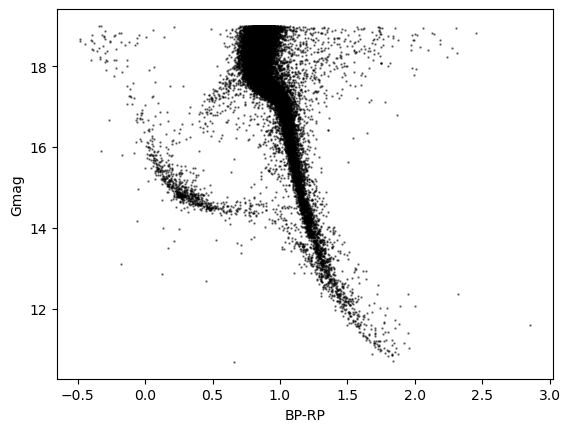

In [14]:
cluster_members_mass.plot.scatter(
    x='BP-RP', 
    y='Gmag',
    s=0.5,
    c='000',
    alpha=0.5)
plt.show()